# Analytical stability Plots (Figure 6)

## Before you start

This notebook assumes that the multi-seed analysis has been completed.

The inference outputs are expected to be stored in `../datasets/gibson/output/mdsine2/inference/healthy-seed<SEED>`, as generated by `scripts/analysis/mdsine2_infer_all.sh`. The relevant analysis outputs can be downloaded from zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.8006854.svg)](https://doi.org/10.5281/zenodo.8006854).

## Other Details

Not included in this notebook is the module-level interaction network visualization (Fig. 6D1). That was rendered using Cytoscape, given inputs from the `mdsine2 interactions-to-cytoscape` command-line interface.
Please run the following command:
```bash
cd MDSINE2_Paper/datasets/gibson/output/mdsine2/inference/merged_studies_fixed_cluster
mdsine2 interactions-to-cytoscape -i mcmc.pkl -o interactions_for_cytoscape.json
```
and open the resulting JSON file through cytoscape.

In [1]:
from typing import *
from pathlib import Path
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy.stats
from statsmodels.stats.multitest import fdrcorrection

import mdsine2 as md2
from mdsine2.names import STRNAMES

from tqdm.notebook import tqdm

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

[DEBUG] Using default logger (stdout, stderr).


In [2]:
data_dir = Path('../datasets/gibson/healthy/output/mdsine2/inference')

In [4]:
seed_paths = [
    data_dir / f"healthy-seed{seed}" / "mcmc.pkl"
    for seed in range(10, 21, 1)
    if seed != 18
]
for p in seed_paths:
    if not p.exists():
        print(f"File path {p} does not exist!")

## Part 1: Cycles assorted by sign & Eigenvalues (across all taxa)

In [3]:
def modules_from_cocluster(M) -> Iterator[np.ndarray]:
    indices = set(range(M.shape[-1]))
    while len(indices) > 0:
        v = next(iter(indices))
        module = np.where(M[v])[0]
        for w in module:
            indices.remove(w)
        yield module

        
def extract_interactions(mcmc: md2.BaseMCMC) -> np.ndarray:
    interactions = mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(section='posterior')
    interactions[np.isnan(interactions)] = 0

    self_interactions = mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk(section='posterior')
    self_interactions = -np.absolute(self_interactions)

    for i in range(self_interactions.shape[1]):
        interactions[:, i, i] = self_interactions[:, i]
    return interactions
        

def module_interactions_all(mcmc_paths: Path) -> Iterator[np.ndarray]:
    """
    Extract the interaction matrices from the MCMC pickle path.
    """
    for mcmc_path in mcmc_paths:
        mcmc = md2.BaseMCMC.load(str(mcmc_path))
        yield from extract_module_interaction(mcmc)


def extract_module_interaction(mcmc: md2.BaseMCMC) -> Iterator[np.ndarray]:
    interactions = extract_interactions(mcmc)
    cocluster = mcmc.graph[STRNAMES.CLUSTERING_OBJ].coclusters.get_trace_from_disk(section='posterior')

    n_samples = interactions.shape[0]

    for i in range(n_samples):
        modules = list(modules_from_cocluster(cocluster[i]))
        module_reps = [next(iter(module)) for module in modules]
        module_interactions = interactions[i][np.ix_(module_reps, module_reps)]
        for j in range(module_interactions.shape[0]):
            module_interactions[j, j] = 0.
        yield module_interactions


def count_signed_cycles(mat):
    '''
    Count length 2 and 3 cycles, given a particular interaction matrix (corresp. to a single gibbs sample).
    '''
    adj = np.copy(mat).T
    plus_adj = np.zeros(shape=adj.shape, dtype=int)
    plus_adj[adj > 0] = 1
    minus_adj = np.zeros(shape=adj.shape, dtype=int)
    minus_adj[adj < 0] = 1
    
    return {
        '++': _count_cycles_with_sign(['++'], plus_adj, minus_adj) / 2,
        '--': _count_cycles_with_sign(['--'], plus_adj, minus_adj) / 2,
        '+-': _count_cycles_with_sign(['+-', '-+'], plus_adj, minus_adj) / 2,
        '+++': _count_cycles_with_sign(['+++'], plus_adj, minus_adj) / 3,
        '---': _count_cycles_with_sign(['---'], plus_adj, minus_adj) / 3,
        '++-': _count_cycles_with_sign(['++-', '+-+', '-++'], plus_adj, minus_adj) / 3,
        '--+': _count_cycles_with_sign(['--+', '-+-', '+--'], plus_adj, minus_adj) / 3,
    }

def _count_cycles_with_sign(signs, plus, minus):
    """
    Multiply adjacency matrices to count the number of cycles. Example: #(+-+) = Trace[(M+) * (M-) * (M+)]
    """
    ans = 0
    for pattern in signs:
        M = np.eye(plus.shape[0])
        for sign in pattern:
            if sign == "+":
                M = M @ plus
            elif sign == "-":
                M = M @ minus
        ans = ans + np.sum(np.diag(M))
    return ans


def permute_matrix(A):
    m, n = A.shape
    B = np.zeros(A.shape)
    for r in range(m):
        row = A[r, :]
        row = np.concatenate([ row[:r], row[r+1:] ])  # without diagonal element
        perm_row = row[np.random.permutation(len(row))]  # permute non-diagonal entry of each row
        perm_row = np.concatenate([ perm_row[:r], [A[r, r]], perm_row[r:] ])
        B[r, :] = perm_row
    return B


def compute_signed_statistics(interactions, permute: bool = False, pbar_desc: str = None, num_samples: int = 100000) -> pd.DataFrame:
    """
    Loop through each gibbs sample. For each gibbs sample, compute the number of cycles, assorted by sign.
    (Does not tell us exactly which cycles appear frequently.)
    """
    entries = []
    
    signs = ['++', '--', '+-', '+++', '---', '++-', '--+']
    for idx, mat in tqdm(enumerate(interactions), total=num_samples, desc=pbar_desc):
        if permute:
            mat = permute_matrix(mat)
        signed_cycle_counts = count_signed_cycles(mat)
        for sgn, ct in signed_cycle_counts.items():
            entries.append({
                'SampleIdx': idx,
                'Sign': sgn,
                'Count': int(ct)
            })
    return pd.DataFrame(entries)


def compute_eigenvalue_statistics(interactions, permute: bool = False, pbar_desc: str = None, num_samples: int = 100000) -> pd.DataFrame:
    """
    Loop through each gibbs sample. For each gibbs sample, compute the number of cycles, assorted by sign.
    (Does not tell us exactly which cycles appear frequently.)
    """
    entries = []
    
    for idx, mat in tqdm(enumerate(interactions), total=num_samples, desc=pbar_desc):
        if permute:
            mat = permute_matrix(mat)
        evals = np.linalg.eigvals(mat)
        ct = np.sum(evals.real > 0)
        entries.append({
            'Idx': idx,
            'Count': ct
        })
        
    return pd.DataFrame(entries)

### Dataset

### Cycle counts by sign

In [5]:
base_cycle_df = compute_signed_statistics(
    module_interactions_all(seed_paths),
    permute=False
)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [6]:
permuted_cycle_df = compute_signed_statistics(
    module_interactions_all(seed_paths),
    permute=True
)

  0%|          | 0/100000 [00:00<?, ?it/s]

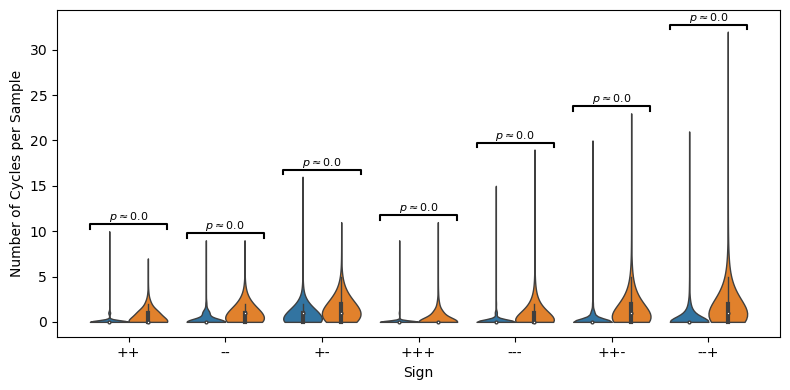

In [7]:
palette = {'Base': 'tab:blue', 'Permuted': 'tab:orange'}
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# ================ Cycles
combined_df = pd.concat([base_cycle_df.assign(src="Base"), permuted_cycle_df.assign(src="Permuted")])
sb.violinplot(
    data=combined_df,
    x='Sign',
    y='Count',
    cut=0,
    scale='count',
    hue="src",
    ax=ax,
    bw=0.7,
    palette=palette,
    linewidth=1.
)


def annot_pvalue(_ax, pvalue, x, y, h, w, color='black'):
    # statistical annotation
    x1, x2 = x - w, x + w   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    _ax.plot([x1, x1, x2, x2], [y+0.5*h, y+1.5*h, y+1.5*h, y+0.5*h], lw=1.5, c=color)
    if pvalue == 0:
        label = fr"$p\approx{pvalue}$"
    else:
        label = fr"$p={pvalue}$"
    _ax.text(x, y+1.5*h, label, ha='center', va='bottom', color=color, size=8.)


diff_df_entries = []
pvals = []
sgns = ['++', '--', '+-', '+++', '---', '++-', '--+']
for sgn in sgns:
    _x = base_cycle_df.sort_values('SampleIdx').loc[base_cycle_df['Sign'] == sgn, 'Count'].to_numpy()
    _y = permuted_cycle_df.sort_values('SampleIdx').loc[permuted_cycle_df['Sign'] == sgn, 'Count'].to_numpy()
    _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
    pvals.append(_pval)
    diff_df_entries.append({
        'Sign': sgn,
        'Diff': np.mean(_y) - np.mean(_x)
    })
diff_df = pd.DataFrame(diff_df_entries)

_, bh_pvals = fdrcorrection(pvals)
for x, (sgn, bh_pval) in enumerate(zip(sgns, bh_pvals)):
    if bh_pval < 0.05:
        y = combined_df.loc[combined_df['Sign'] == sgn, 'Count'].max()
        annot_pvalue(ax, bh_pval, x, y, h=0.5, w=0.4, color='black')


ax.get_legend().remove()
ax.set_xlabel('Sign')
ax.set_ylabel('Number of Cycles per Sample')
fig.tight_layout()

### Eigenvalues

In [9]:
def _interaction_gen(mcmc_path):
    interactions = extract_interactions(md2.BaseMCMC.load(mcmc_path))
    for mat in interactions:
        yield mat


base_eig_df = compute_eigenvalue_statistics(
    itertools.chain(*(_interaction_gen(p) for p in seed_paths)),
    permute=False
)

permuted_eig_df = compute_eigenvalue_statistics(
    itertools.chain(*(_interaction_gen(p) for p in seed_paths)),
    permute=True
)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

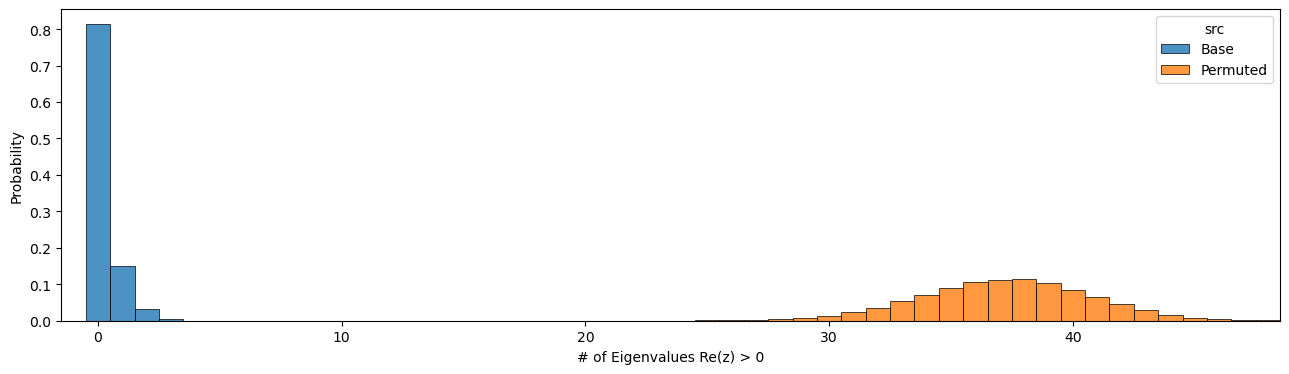

In [10]:
palette = {'Base': 'tab:blue', 'Permuted': 'tab:orange'}
fig, ax = plt.subplots(1, 1, figsize=(13, 3.85))


# =============== Eigenvalues
combined_df = pd.concat([base_eig_df.assign(src="Base"), permuted_eig_df.assign(src="Permuted")]).reset_index()
sb.histplot(
    data=combined_df,
    common_norm=False,
    x='Count',
    bins=np.arange(0, 85, 1.0)-0.5,
    hue='src',
    ax=ax,
    palette=palette,
    alpha=0.8,
    linewidth=0.5,
    stat='probability'
)
ax.set_xlim([np.min(base_eig_df['Count']) - 1.5, np.quantile(permuted_eig_df['Count'], q=0.999) + 0.5])
ax.set_xlabel('# of Eigenvalues Re(z) > 0')
fig.tight_layout()

## Part 2: Breakdown of cycle types by Bayes Factor (Fixed cluster)

This is computed (and is really only clearly defined for) the fixed-module inference.

The output is expected to be stored in `../datasets/gibson/output/mdsine2/inference/merged_studies_fixed_cluster`, which is generated by `scripts/analysis/mdsine2_infer_fixedcluster.sh`.

The cells below also require extracted posteriors merged across the seeds, stored in `../datasets/gibson/output/mdsine2/inference/merged_studies`, which is automatically done by the script `scripts/analysis/mdsine2_infer_all.sh`.

In [14]:
def count_cycles(A: np.ndarray, cycle_sgn: str):
    matrices = [
        A > 0 if sgn == "+" 
        else A < 0
        for sgn in cycle_sgn
    ]

    prod = matrices[0].astype(int)
    for m in matrices[1:]:
        prod = prod @ m

    return np.diag(prod).sum()


def interaction_bayes_factors(interactions: np.ndarray, prior_a: float, prior_b: float) -> np.ndarray:
    trace = ~np.isnan(interactions)
    cnts_1 = np.sum(trace, axis=0)
    cnts_0 = np.sum(1-trace, axis=0)

    return (cnts_1 * prior_b) / (cnts_0 * prior_a)


class MdsineOutput(object):
    '''
    A class to encode the data output by MDSINE.
    '''
    def __init__(self, pkl_path):
        self.mcmc = md2.BaseMCMC.load(pkl_path)
        self.taxa = self.mcmc.graph.data.taxa
        self.name_to_taxa = {otu.name: otu for otu in self.taxa}

        self.interactions = None
        self.clustering = None

        self.clusters_by_idx = {
            (c_idx): [self.get_taxa(oidx) for oidx in cluster.members]
            for c_idx, cluster in enumerate(self.get_clustering())
        }

    @property
    def num_samples(self) -> int:
        return self.mcmc.n_samples

    def get_cluster_df(self):
        return pd.DataFrame([
            {
                "id": cluster.id,
                "idx": c_idx+1,
                "otus": ",".join([self.get_taxa(otu_idx).name for otu_idx in cluster.members]),
                "size": len(cluster)
            }
            for c_idx, cluster in enumerate(self.clustering)
        ])

    def get_interactions(self):
        if self.interactions is None:
            self.interactions = self.mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(section='posterior')
        return self.interactions

    def get_taxa(self, idx):
        return self.taxa.index[idx]

    def get_taxa_by_name(self, name: str):
        return self.name_to_taxa[name]

    def get_taxa_str(self, idx):
        tax = self.taxa.index[idx].taxonomy
        family = tax["family"]
        genus = tax["genus"]
        species = tax["species"]

        if genus == "NA":
            return "{}**".format(family)
        elif species == "NA":
            return "{}, {}*".format(family, genus)
        else:
            return "{}, {} {}".format(family, genus, species)

    def get_taxa_str_long(self, idx):
        return "{}\n[{}]".format(self.get_taxa(idx).name, self.get_taxa_str(idx))

    def get_clustering(self):
        if self.clustering is None:
            self.clustering = self.mcmc.graph[STRNAMES.CLUSTERING_OBJ]
            for cidx, cluster in enumerate(self.clustering):
                cluster.idx = cidx
        return self.clustering

    def get_clustered_interactions(self):
        clusters = self.get_clustering()
        otu_interactions = self.get_interactions()
        cluster_interactions = np.zeros(
            shape=(
                otu_interactions.shape[0],
                len(clusters),
                len(clusters)
            ),
            dtype=float
        )
        cluster_reps = [
            next(iter(cluster.members)) for cluster in clusters
        ]
        for i in range(cluster_interactions.shape[0]):
            cluster_interactions[i] = otu_interactions[i][np.ix_(cluster_reps, cluster_reps)]
        return cluster_interactions

In [12]:
# Calculate module-level cycle counts.

n_modules = len(set(np.load(data_dir / 'merged_studies' / 'agglomeration.npy')))
a = 0.5
b = n_modules * (n_modules - 1)

md_fixed_module = MdsineOutput(data_dir / 'merged_studies_fixed_cluster' / 'mcmc.pkl')

A = md_fixed_module.get_clustered_interactions()
bf = interaction_bayes_factors(A, a, b)
signs = np.sign(np.sum(A > 0, axis=0) - np.sum(A < 0, axis=0))



thresholds = [np.sqrt(10), 10, 100]
# thresholds = [10]
labels = [
    r'$\sqrt{10}$',
    r'$10$',
    r'$100$'
]

cycle_signs = ['++', '--', '+-', '-+']
sign_groups = [['++'], ['--'], ['+-', '-+']]
sign_order = [s[0] for s in sign_groups]
sign_colors = {
    '++': 'tab:blue',
    '--': 'tab:orange',
    '+-': 'tab:green'
}

true_counts = np.zeros((len(thresholds), len(sign_groups)), dtype=int)
_locs = {s: i for i, s in enumerate(sign_order)}
for thres_idx, t in enumerate(thresholds):
    edges = bf > t
    filt_edges = np.zeros(signs.shape, dtype=int)
    filt_edges[edges] = signs[edges]
    
    true_counts[thres_idx, _locs['++']] = count_cycles(filt_edges, '++') // 2
    true_counts[thres_idx, _locs['--']] = count_cycles(filt_edges, '--') // 2
    true_counts[thres_idx, _locs['+-']] = count_cycles(filt_edges, '+-')  # only need to count these once.

true_freqs = true_counts / true_counts.sum(axis=1, keepdims=True)

Threshold = 3.1622776601683795, # 2-cycles = 40
Threshold = 10, # 2-cycles = 9
Threshold = 100, # 2-cycles = 1


Text(0, 0.5, 'Bayes Factor')

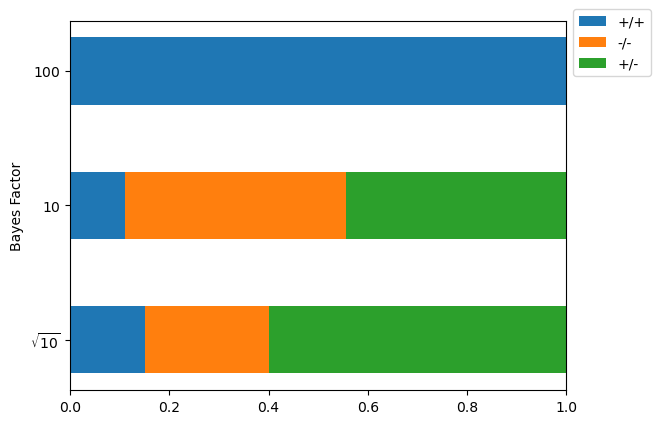

In [13]:
# Display counts
for t_idx, t in enumerate(thresholds):
    print("Threshold = {}, # 2-cycles = {}".format(t, true_counts[t_idx, :].sum()))



fig, ax = plt.subplots()
offset = np.zeros(len(thresholds))

for sgn_idx, sgns in enumerate(sign_groups):
    h = true_freqs[:, sgn_idx]
    c = sign_colors[sgns[0]]
    ax.barh(labels, h, left=offset, color=c, height=0.5, label='/'.join(sgns[0]))
    offset = offset + h
    
lgd = ax.legend(bbox_to_anchor=(1.0, 1.05), loc='upper left')
ax.set_xlim([0, 1])

ax.set_ylabel('Bayes Factor')

# Part 3: Significance of cycle ratio (++ to --, Figure 6D3)

In [69]:
# Functions
def generate_permutation(A):
    """Permute each row, so that the diagonal entries stay fixed."""
    m, n = A.shape
    B = np.zeros(A.shape)
    for r in range(m):
        row = A[r, :]
        row = np.concatenate([ row[:r], row[r+1:] ])  # without diagonal element
        perm_row = row[np.random.permutation(len(row))]  # permute non-diagonal entry of each row
        perm_row = np.concatenate([ perm_row[:r], [A[r, r]], perm_row[r:] ])
        B[r, :] = perm_row
    return B


def calc_randomized_cycles(signed_edges):
    perm_signed_edges = generate_permutation(signed_edges)
    return {
        '++': count_cycles(perm_signed_edges, '++') // 2,
        '--': count_cycles(perm_signed_edges, '--') // 2,
        '+-': count_cycles(perm_signed_edges, '+-')
    }


def plot_cycle_ratio(bf_threshold, sign1, sign2, ax):
    # Randomized statistic
    _entries = []
    for i, x in df.loc[
        df['BF'] == bf_threshold,
        ['Trial', 'Sign', 'Count']
    ].groupby('Trial'):
        a = x.loc[x['Sign'] == sign1, 'Count'].item()
        b = x.loc[x['Sign'] == sign2, 'Count'].item()
        if b == 0:
            continue
        _entries.append({'Trial': i, 'Ratio': a / b})
    ratio_df = pd.DataFrame(_entries)
    
    # Observed statistic
    edges = bf > bf_threshold
    filt_edges = np.zeros(signs.shape, dtype=int)
    filt_edges[edges] = signs[edges]
    n_pp = count_cycles(filt_edges, sign1)
    n_mm = count_cycles(filt_edges, sign2)

    # Plot
    sb.histplot(data=ratio_df, x='Ratio', bins=50, ax=ax)
    ax.axvline(n_pp / n_mm, color='red')
    ax.set_title(r'BF $\geq$ {}'.format(bf_threshold))

In [70]:
# Code to compute the statistics
n_trials = 10000
df_entries = []


n_modules = len(set(np.load(data_dir / 'merged_studies' / 'agglomeration.npy')))
a = 0.5
b = n_modules * (n_modules - 1)

md_fixed_module = MdsineOutput(data_dir / 'merged_studies_fixed_cluster' / 'mcmc.pkl')
A = md_fixed_module.get_clustered_interactions()
bf = interaction_bayes_factors(A, a, b)
signs = np.sign(np.sum(A > 0, axis=0) - np.sum(A < 0, axis=0))

for t in thresholds:
    edges = bf > t
    filt_edges = np.zeros(signs.shape, dtype=int)
    filt_edges[edges] = signs[edges]
    for i in tqdm(range(n_trials), desc=f'Threshold {t}'):
        for sgn, ct in calc_randomized_cycles(filt_edges).items():
            df_entries.append({
                'BF': t, 'Trial': i, 'Sign': sgn, 'Count': ct
            })

df = pd.DataFrame(df_entries)
del df_entries

df['Sum'] = df.groupby(['BF', 'Trial'])['Count'].transform('sum')
df['Frac'] = df['Count'] / df['Sum']

Threshold 3.1622776601683795:   0%|          | 0/10000 [00:00<?, ?it/s]

Threshold 10:   0%|          | 0/10000 [00:00<?, ?it/s]

Threshold 100:   0%|          | 0/10000 [00:00<?, ?it/s]

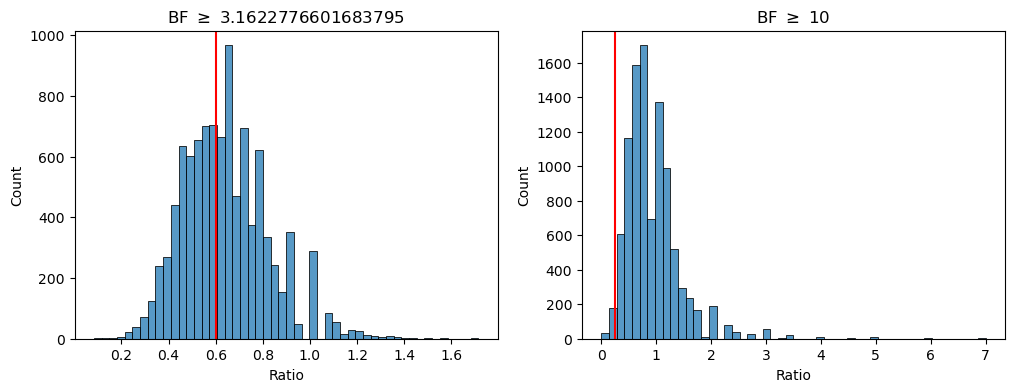

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_cycle_ratio(thresholds[0], '++', '--', axes[0])
plot_cycle_ratio(thresholds[1], '++', '--', axes[1])